# Electric Feed System Pump Size Estimates
We're exploring the use of an all-electric pump for the propellant feed system. What follows is a preliminary pump sizing and requirements analysis to guide further inquiry.

## Design Approach
Turbomachines, contrary to popular belief, are not not powered by black magic (largely). The process for determining pump requirements is a straight forward one. First we need to establish design goals. High efficiency, high performance, and minimum mass are desirable from a vehicle mass faction standpoint. But designs that increase efficiency and decrease mass can also increase pump-inlet pressure required to suppress cavitation, which can in turn lead to increases in propellant tank mass. Also we do not wish to compromise design simplicity, reliability, operational life, and cost. In some sense these are hard tradeoffs. So we should first define the relative importance/emphasis of these design goals.

## Design Inputs
Engine and vehicle requirements dictate the types, flow rates and pressure levels of the propellants that the pumps deliver to the engine thrust chamber. These are assumed to be given from an earlier and more fundamental analysis of vehicle design. The pumps must deliver propellant without requiring an inlet pressure greater that that allowed by other parts of the feed system. A pump operating under a specified condition (rotational speed and fluid angles of attack on internal surfaces) produce a constant-volume flow rate and constant head rise. To summarize the (given) inputs are propellant mass flow rate, pump pressure rise, pump inlet pressure, and physical and derived quantities such as propellant density and vapor pressure, volume flow rate and NPSH. Q is given by

$$
Q = \frac{\dot{m}}{\rho}
$$

where $\dot{m}$ is the mass flow rate, and $\rho$ is the fluid density.

The pump head rise is given by

$$
H_p = \frac{\Delta p_p}{g_0 \rho}
$$

where $\Delta p_p$ is the required rise in pressure and $g_0$ is the gravitational acceleration.

Available Net Positive Suction Head is given by 

$$
NPSH_{available} = \frac{p_i - p_v}{g_0 \rho}
$$

Note that this formulation of $NPSH$ assumes that the elevation head (including the additional head due to acceleration of the launch vehicle) is small relative to the vapor pressure and tank pressure.

Also note that due to the preponderence of barleycorn units used in hydraulic engineering this document will use them as well, both by convention, and also due to the fact that most vendor data sheets are provided in that unit system.

## Useful Physical Properties of Propellants
|         | density $\rho$ [kg/m^3] | vapor pressure $p_v$ [Pa] |
|-------- | ----------------------- | ---------------------------|
| ethanol | 789                     | 8.84E3                     |
| LOX     | 1141                    | 5E6                        |

In [1]:
import math as m

# propellant properties and physical constants

rho = 789                             # propellant density (ethanol and LOX respectively) [kg/m^3]
p_v = 8.84E3                          # propellant vapor pressure [Pa]
g_0 = 9.81                            # gravitational acceleration [m/s/s]
 
# rocket model (assuming sea-level operation)

isp = 246 * 0.90                          # specific impulse (sea-level, optimistic estimate) [s]
f = 4.5E3                                 # thrust [N]
mdot_t = f/(g_0 * isp)                    # total mass flowrate [kg/s]
chamber_p= 380 * 6.895 * 1000             # chamber pressure (assumed to be 380 psi currently) [Pa] 
loss_factor = 1.15                        # estimate of line and injector losses
OF = 1.3                                  # mixture ratio
mdot_o = mdot_t / (1 + (1/OF))            # oxidizer mass flowrate [kg/s]
mdot_f = mdot_t / (1 + OF)                # fuel mass flowrate [kg/s]
p_i = 101.3E3                             # inlet pressure (currently 1 atm) [Pa]
delta_p = chamber_p * loss_factor - p_i   # required pump discharge pressure [Pa]

#barleycorn conversions
g_0 = 32.2
delta_p = delta_p * 0.000145038
mdot = mdot_f * 2.20462
rho = rho * 0.062428
h_i = p_i * 0.000145038 * 144 / rho
h_v = p_v * 0.000145038 * 144 / rho

# derived parameters

q = mdot / rho                      # volumetric flowrate [f^3/s]
h_p = 144 * delta_p / rho           # required head rise [ft]
npsh_a = h_i - h_v    # Net Positive Suction Head (available) [ft]

print("mass flow rate")
print("%.3f" % mdot, "lbm/s ", "\n")
print("volumetric flow rate")
print("%.4f" % q, "ft^3/s", "\n")
print("required pressure head")
print("%.3f" % h_p, "ft", "\n")
print("Net Positive Suction Head Available")
print("%.3f" % npsh_a, "ft")

mass flow rate
1.986 lbm/s  

volumetric flow rate
0.0403 ft^3/s 

required pressure head
1234.672 ft 

Net Positive Suction Head Available
39.205 ft


A brief vendor search shows that there are no COTS pump solutions that even remotely approach satisfying our requirements with reasonable weights and pricepoints. On possibility is to accept a lower chamber pressure, or to jack up the pressure at the pump inlet by pressurizing the propellant tanks. This has the advantage of making the required pump head more reasonable, and should additionally help supress cavitation within the pump. The disadvantage is that it goes against the original point of using pumps especially to enable thin and lightwight propellant tanks. 

## Design Outputs
Given the requirements and the design inputs there are six basic steps needed to size a pump.

1. Determine the number of stages.
2. Determine the pump rotational speed.
3. Determine the pump impeller tip speeds.
4. Determine the pump impeller entrance and exit tip diameters
5. Determine pump efficiency
6. Determine the shaft power required to drive the pump.


## Determine Number of Stages
The number of stages is generally either determined by the next largest integer value greater than the ratio of the pump-pressure rise to the maximum allowable stage-pressure rise, or by $NPSH_{required}$. If a centrifugal pump is used the approximate limits on stage-pressure rise is  47MPa for LOX and ethanol (citation needed). At 47 MPa impeller tips become so thick that they restrict flow passages and develop large k-losses. We determine the number of stages from a simple rule of thumb

$$ \label{eqn:1}
n \geq \frac{\Delta p_p}{\Delta p_s}
$$

where $\Delta p_p$ is the required pressure rise and we assume $\Delta p_s$ to be 47MPa.

In [2]:
# number of stages

delta_p_s = 47E6 * 0.000145038         # estimated allowable pressure rise per stage [Pa]
n = int(m.ceil(delta_p/delta_p_s))     # number of stages

print("number of stages")
print(n)

number of stages
1


## Determine Pump Rotational Speed
The next step is to estimate the impeller-tip speeds, rotational speed, and finally impeller sizes. Impeller tip speed is given by

$$ \label{eqn:2}
u_t = \psi \sqrt{\frac{2 g_0 H_p}{n}}
$$

where $\psi$ is the pump-stage head coefficient which we can assume to have a numerical value of between 0.4 and 1.5 (citation needed). As mentioned previously we want the highest rotational speed to get the lowest pump mass and highest performance, however there are practical constraints on things such as bearings. If there is no boost stage and and if there is a definite NPSH limit the pump rotational speed in $rad/s$ can be determined by 

$$ \label{eqn:3}
N_r = \frac{u_{ss}NPSH^{0.75}}{\sqrt{Q}}
$$

Suction-specific speed, $u_{ss}$, indicates the minimum net positive suction head (NPSH, inlet pressurization above the vapor pressure expressed in meters) at which a pump operating at rotational speed $N$, and volume flow rate $Q$, can operate without cavitation effects. $u_{ss}$ values fall between 5000 and 50,000 depending on efficiency of the pump with 7000 to 12,000 being typical. Lower numbers are more conservative. A large suction-specific speed indicates an ability to operate at low inlet pressures. Large values are obtained by using large diameters for the pump-inlet tip and small diameters for the inlet hub such that the inlet axial velocity head is minimized. Additionally thin, gradually curved blades with sharp leading edges produce the minimum static pressure gradients on the blade surfaces. Inducers have both features, and are therefore widely used in pumping applications on rocket engines. The important thing is that the $NPSH_{available}$ must be higher than $NPSH_{required}$ to avoid cavitation. $NPSH_{required}$ is determined on a pump by pump basis. This places the upper limit on impeller specific speed. If additional head is required by the pump  the propellant needs to be pre-pressurized before reaching the pump impeller, such as with the aformentioned inducer, or with additional pump stages (e.g. 'booster' stages), or by pressurizing the propellant tank. As a historical note the German V-2 oxygen tank was pressurized to 2.3 atm (autogenuously) largely to suppress pump cavitation.

$$ \label{eqn:4}
N_s = \frac{N_r \sqrt{Q}}{(\frac{H_p}{n})^{0.75}}
$$

$N_s$ is the stage-specific speed where $N_r$ is the pump's rotational speed and $n$ is the number of stages. Stage specific speed, $N_s$, is a parameter that characterizes geometrically and hydrodynamically similar pumps. Centrifugal pump are generally low-capacity/high-head devices and thus are at the low specific speed side of the spectrum. Each class of pump (radial, francis, mixed, axial) lends itself to a particular range of specific speeds.


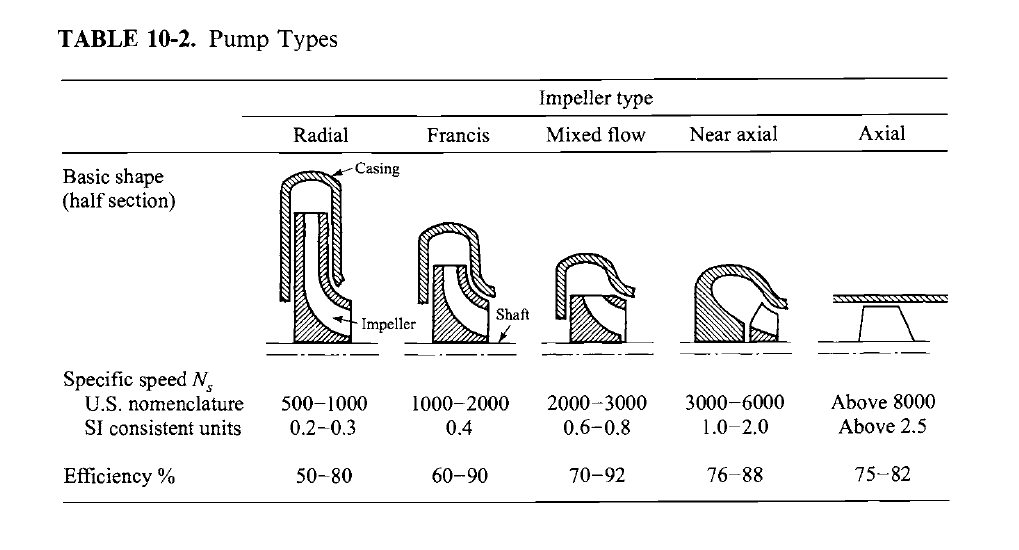

In [3]:
from IPython.display import Image
Image(filename='specific_speed.png') 

In [4]:
# pump rotational speed

psi = 1                                         # pump stage head coefficient (estimated)
u_t = psi * m.sqrt(2 * g_0 * h_p)               # impeller vane tip speed [ft/s]
u_ss = 10E3                                     # suction specific speed
npsh_r = npsh_a * 0.8
n_r = (u_ss * npsh_r**0.75)/(21.2 * m.sqrt(q))  # pump rotational speed [RPM]
n_r_rad = n_r * 2 * m.pi / 60
n_s = (21.2* n_r * m.sqrt(q))/(h_p / n)**0.75   # pump specific speed

print("impeller tip speed")
print("%.2f" % u_t, "ft/s", "\n")
print("pump rotational speed")
print("%.2f" % n_r, "RPM", "\n")
print("pump specific speed")
print("%.2f" % n_s)


impeller tip speed
281.98 ft/s 

pump rotational speed
31133.67 RPM 

pump specific speed
636.30


It should be noted that the combination of flowrate, pressure rise and fluid density togeather with the allowable range of speeds places the pump in the very low end of the specific speed range, where the predicted maximum attainable efficicency for several types of centrifugal pumps are below those of positive displacement type pumps. It is not likely that an efficiency beter than 50% is attainable; as such several stages may be required for the desired capacity. Positive dispalcement type pumps may offer improved efficiency at the cost of less steady flow, noise, and much poorer reliability.

Additionally, it's difficult to extrapolate pump efficiencies availabile in literature to such small high-head pumps, as the implicit assumption of geometric and hydrodynamic similarity may well be broken.

## Impeller Diameters
Knowing the rotational speed, we can get the  impeller diameters using

$$ \label{eqn:5}
D_o = \frac{u_t}{N_r}
$$
$$ \label{eqn:6}
D_i = \left( \frac{4Q}{\pi \phi N_r(1 - L^2)} \right)^{1/3}
$$

Where $D_o$ is the diameter of the impeller outlet ($m$), also called the discharge, $D_i$ is the diameter of the impeller inlet ($m$), $L$ is the ratio of the hub diameter to the tip diameter, and $\phi$ is the inducer-inlet flow coefficient. Minimizing the factors $\phi$ and $L$ minimizes the NPSH required by the pump. The inducer-inlet flow coefficient, $\phi$, is the tangent of the flow angle approaching the inducers blade tip. It is one of the main design parameters used to maximize suction performance. Generally, lower values are better. Assume 0.1 if using inducer, otherwise use 1.

In [5]:
# impeller diameters

l = 0.3                                                        # hub to tip diameter ratio (assume 0.3)
phi = 1                                                        # inducer flow coefficicent (assume 0.1 with inducer, 1.0 otherwise)
d_o = u_t * 2 / n_r_rad * 12                                   # impeller outer diameter [in]
d_i = (4 * q/(m.pi * phi * n_r_rad * (1 - l**2)))**(1/3) * 12  # impeller inner diameter [in]

print("impeller discharge diameter")
print("%.3f" % d_o, "in", "\n")
print("impeller inlet diameter")
print("%.4f" % d_i, "in")


impeller discharge diameter
2.076 in 

impeller inlet diameter
0.3104 in


## Shaft Power
The required shaft power can be determined from

$$ \label{eqn:7}
P_{req} = \frac{g_0 \dot{m} H_p}{\eta_p}
$$

where $\eta_p$ is the pump efficiency and can be determined from the stage-specific speed and tabulated efficiency data.

In [8]:
# shaft power

from numpy import interp

#from a table of efficiencies for radial impellers found in Munson et. al., 2009 
def effic(n_s):
    eta_t = [0.55, 0.80, 0.83, 0.85, 0.84, 0.82]
    n_s_t = [500, 1000, 1500, 2000, 2500, 3000]
    eta = interp(n_s, n_s_t, eta_t)
    return eta

eff = 0.4 # a more realistic estimated efficiency
#eta = input('given an pump specific speed of {} and flow rate of {} m^3/s what is the pump efficiency (from a lookup table in Munson) '.format("%.3f" % n_s, "%.3f" % q))
def power(mdot, h_p, n_s):  # required shaft power [W]
    p_req = mdot * h_p/(effic(n_s) * 0.738)
    return p_req

print("pump efficiency")
print("%.2f" % float(100*effic(n_s)), "%", "\n")
print("required shaft power (optimistic)")
print("%.2f" % power(mdot, h_p, n_s), "W", "\n")
print("required shaft power (realistic)")
print("%.2f" % power(mdot,h_p, eff), "W")

pump efficiency
61.81 % 

required shaft power (optimistic)
5374.95 W 

required shaft power (realistic)
6040.94 W


It should be noted that 62% is very optimistic for any hombrew pump volute/inducer/impeller combination. We should count ourselves lucky if we hit 40% efficient.

In [7]:
f_t = 50                                              #engine run time [s]
print("%.2f" % float(power(mdot,h_p, eff)*f_t/1000), "kJ")  #Total stored energy [kJ]

302.05 kJ
